In [4]:
#!{sys.executable} -m pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets

In [23]:
def filter_df(df_orig, col, arg, op='=='):
    df = df_orig.copy()
    
    if op == '==':
        df = df.loc[df[col]==arg]
    elif op == '<':
        df = df.loc[df[col]<arg]
    elif op == '>':
        df = df.loc[df[col]>arg]
    elif op == '<=':
        df = df.loc[df[col]<=arg]
    elif op == '>=':
        df = df.loc[df[col]>=arg]
    elif op == '!=':
        df = df.loc[df[col]!=arg]
    elif op == 'isin':
        assert(type(arg) is list)
        df = df.loc[df[col].isin(arg)]
    else:
        print('op type not supported!')
        assert(1==0)
    
    return df

def get_path(path_string):
    path_list = [int(node_id) for node_id in path_string.split(sep=';')[2:]]
    return path_list

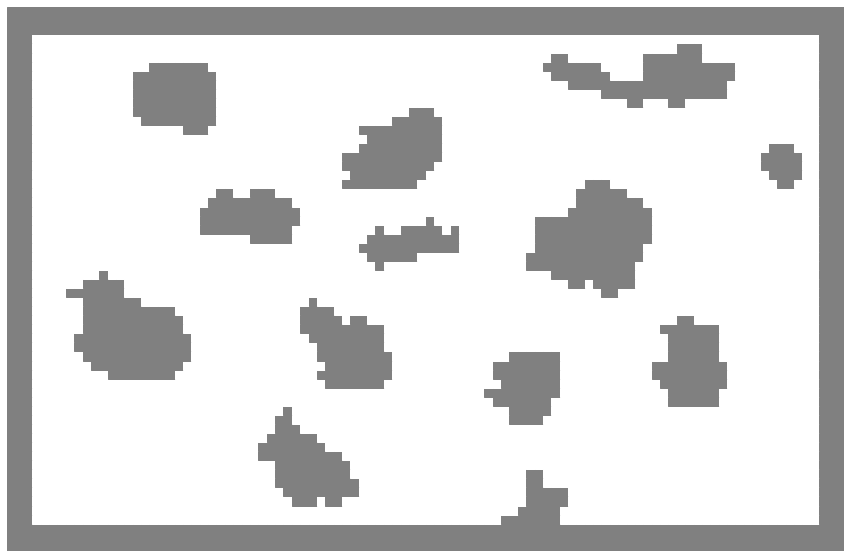

In [46]:
config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
config_dict = config_df.to_dict(orient='list')


fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))

padding=0
ax.set_xlim(0-padding, 100+padding)
ax.set_ylim(0-padding, 60+padding)

ax.axis('off')

# Add obstacles
if (config_dict['use_occupancy_grid'][0] == 0):
    if config_dict['obstacle_cost'][0] > 0:
        for obstacle_nr in range(0,4):
            obst_id_rad = 'obstacle_rad_'+str(obstacle_nr)
            obst_id_x = 'obstacle_pos_'+str(obstacle_nr)+'_x'
            obst_id_y = 'obstacle_pos_'+str(obstacle_nr)+'_y'

            ellipse_plot_0 = patches.Circle((config_dict[obst_id_x][0],config_dict[obst_id_y][0]), 
                                     radius=config_dict[obst_id_rad][0], color='gray')

            ax.add_patch(ellipse_plot_0)
else:
    grid = pd.read_csv(config_dict['grid_path'][0], header=None).to_numpy()

    for row in range(0, grid.shape[0]):
        for column in range(0, grid.shape[1]):
            if (grid[59-row, column] == 0):
                color='w'
            else:
                color='gray'

            grid_cell = patches.Rectangle((column, row),1,1, color=color)

            ax.add_patch(grid_cell)

fig.savefig('rendered_grid.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0,
        metadata=None)



In [53]:
config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
display(config_df)
config_dict = config_df.to_dict(orient='list')

sim_df = pd.read_csv("../cmake-build-debug/sim_log.txt", sep=",", header=0)
display(sim_df.head())

sampling_df = pd.read_csv("../cmake-build-debug/sampling_log.txt", sep=",", header=0)
display(sampling_df)

,sim_time,rollouts,horizon,obstacle_cost,use_occupancy_grid,grid_path,obstacle_rad_0,obstacle_rad_1,obstacle_rad_2,obstacle_rad_3,...,obstacle_pos_1_y,obstacle_pos_2_x,obstacle_pos_2_y,obstacle_pos_3_x,obstacle_pos_3_y,start_state_0,start_state_1,target_state_0,target_state_1,Unnamed: 22
0,200,5,20,10000,1,/home/etienne/git_clone/FDMCTree/grid_python/6...,10,5,10,5,...,15,40,20,80,40,5,5,87,38,NaN


,simstep,state_0,state_1,state_2,state_3,state_4,state_5,Unnamed: 7
0,0,5.00000,5.00000,0.000000,0.000000,0.000000,0.000000,NaN
1,1,4.93468,4.90100,-0.130635,-0.198009,-0.130635,-0.198009,NaN
2,2,4.88230,4.74319,0.025877,-0.117603,0.156512,0.080406,NaN
3,3,4.94669,4.64394,0.102901,-0.080896,0.077023,0.036707,NaN
4,4,5.13656,4.65678,0.276826,0.106570,0.173925,0.187466,NaN


,node_id,simstep,step,rollout,state_0,state_1,state_2,state_3,state_4,state_5,cost_cum,path_to_leaf,Unnamed: 12
0,7,0,0,0,4.93468,4.90100,-0.130635,-0.198009,-0.130635,-0.198009,176.8800,0;0;1;7,NaN
1,8,0,0,1,5.06142,4.96536,0.122846,-0.069272,0.122846,-0.069272,176.7380,0;0;2;8,NaN
2,9,0,0,2,5.04667,4.96098,0.093338,-0.078031,0.093338,-0.078031,176.7540,0;0;3;9,NaN
3,10,0,0,3,4.96612,5.04677,-0.067760,0.093538,-0.067760,0.093538,176.7960,0;0;4;10,NaN
4,11,0,0,4,5.06552,4.98979,0.131030,-0.020420,0.131030,-0.020420,176.7250,0;0;5;11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,20002,199,19,0,89.38060,41.08710,0.492104,0.428409,0.187866,0.013141,22.7386,0;0;1;19907;19912;19917;19922;19927;19932;1993...,NaN
19996,20003,199,19,1,89.77530,34.98050,0.674295,-0.345754,0.078854,0.104947,23.4251,0;0;1;19907;19912;19917;19922;19927;19932;1993...,NaN
19997,20004,199,19,2,87.10340,40.23100,0.027545,0.246637,0.026207,-0.009193,18.2661,0;0;1;19907;19912;19917;19922;19927;19932;1993...,NaN
19998,20005,199,19,3,89.50220,40.46190,0.180684,0.317760,-0.029803,-0.079438,24.0988,0;0;1;19907;19912;19917;19922;19927;19932;1993...,NaN


In [54]:
def draw_interactive(simstep, step):
    
    img = plt.imread("rendered_grid.png")
    
    fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))
    
    ax.imshow(img, extent=[0, 100, 0, 60])

    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)
    
    
    
    # filter data down to relevant data
    df_timestep = filter_df(sampling_df, "simstep", simstep, op='==')
    df_timestep = filter_df(df_timestep, "step", step, op='==')

    # plot start and target position
    ax.scatter(config_df.loc[0,'start_state_0'], config_df.loc[0,'start_state_1'], s=60, marker='o', c='k',zorder=20)
    ax.scatter(config_df.loc[0,'target_state_0'], config_df.loc[0,'target_state_1'], s=60, marker='x', c='k',zorder=20)
    
    # plot path of different rollouts
    for idx, row in df_timestep.iterrows():
        path = get_path(row['path_to_leaf'])
        df_path = filter_df(sampling_df, "node_id", path, op='isin')
        
        ax.plot(df_path[['state_0']], df_path[['state_1']], marker='.', zorder=10)
    
       
    # plot robot, actual and planned path
    ax.plot(sim_df[['state_0']], sim_df[['state_1']], c='k', alpha=0.3)
    ax.plot(sim_df[['state_0']][:simstep+1], sim_df[['state_1']][:simstep+1], c='r')
    ax.scatter(sim_df[['state_0']].iloc[simstep], sim_df[['state_1']].iloc[simstep],s=50, marker='D', c='r',zorder=20)
    
    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)

    
# def on_button_press_map(*arg):
#     process_map()
    
# def on_button_press_data(*arg):
#     load_data()
    
# load_data_button = widgets.Button(description='load data')
# load_data_button.on_click(on_button_press_map)


# load_map_button = widgets.Button(description='load map')
# load_map_button.on_click(on_button_press_data)

# display(load_data_button, load_map_button)
    
controls = widgets.interactive(draw_interactive, 
                    simstep = widgets.IntSlider(value=0, min=0, max=config_dict['sim_time'][0]-1, step=1), 
                    step= widgets.IntSlider(value=19, min=0, max=config_dict['horizon'][0]-1))



display(controls)





interactive(children=(IntSlider(value=0, description='simstep', max=199), IntSlider(value=19, description='ste…